In [1]:
import math
from ipywidgets import widgets
import csv
import random

In [40]:
# %load sim_functions.py
# sim_functions.py
# Frank Mei, Lisa Jian, Michael Jetsupphasuk, My Dinh
# 04 December, 2017
# Functions to simulate lag-adjusted Spearman's rank correlation test for earthquakes

"""
Context: 

Fill me in!

"""

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import rankdata
from scipy.stats import pearsonr

##############################################################################

def largest_corr(rank1, rank2, lag=12, norm=np.inf):
    """
    Given two ranked vectors, take a window of length n-12,
    get a list of lag correlations by shifting the second rank vector,
    return the p-norm correlation in the list (default is maximum correlation).

    For special case of one list containing all same value (e.g. [1,1,1]), the
    correlation will equal one from a divide by 0 error (since sd is 0). For
    these cases, correlation is coerced to 0.
    """

    r1 = rank1[:-12]
    corrs = list(map(lambda i: pearsonr(r1, rank2[i:(len(r1)+i)])[0], range(lag+1)))
    corrs = [0 if math.isnan(cor) else cor for cor in corrs]
    # return np.argmax(corrs) # which lag has the maximum correlation
    return np.linalg.norm(corrs, ord=norm)


def simulate(ranks1, ranks2, num_trials=10000, lag=12, norm=np.inf):
    """
    Given two ranked vectors, repeatedly permute ranks1 and get the 
    p-norm correlation for all lags specified. Return all simulated values.
    """

    # Used to simulate a single trial. The input is not used.
    def simulate_single_trial(_):
        np.random.shuffle(ranks1)
        return largest_corr(ranks1, ranks2, lag, norm)
    
    # Make a copy for ranks1 because np.random.shuffle is in place.
    ranks1 = ranks1.copy()

    return np.array(list(map(simulate_single_trial, range(num_trials))))


def simulate_by_block(ranks1, ranks2, bstart, bsize, lag=12, norm=np.inf, num_trials=10000):
    """
    Like `simulate` above except permutes by block specified by `bstart`
    and `bsize`.
    """

    def simulate_block_trial(_):
        r1, end = block_permute(ranks1, bstart, bsize)
        r2 = ranks2.copy()[bstart : end]
        return largest_corr(r1, r2, lag, norm)

    # Make a copy for ranks1 because block_permute is in place.
    ranks1 = ranks1.copy()

    return np.array(list(map(simulate_block_trial, range(num_trials))))


def p_value(dist, observed):
    """
    Given an empirical distribution `dist`, this function returns the
    probability of seeing `observed` or larger (i.e. this is one-sided).
    The empirical `dist`, for instance, would look like the return of
    the `simulate` function above.
    """

    return np.sum(dist >= observed) / float(len(dist))


def corr_test(lst1, lst2, lag=12, norm=np.inf, bstart=0, bsize=6, plot=True):
    """
    Combining simulation into a test that returns a p-value. Option
    to plot.
    """

    og = largest_corr(lst1, lst2, lag, norm)
    s = simulate_by_block(lst1, lst2, lag=lag, norm=norm, bstart=bstart, bsize=bsize)
    if plot:
        plt.hist(s, bins = 'auto')
        plt.axvline(x = og, color = 'red')
        plt.show()
    return p_value(s, og)


def block_permute(ts, start, length): 
    """
    Each block is defined by the start point of to begin blocking and length of the block. 
    The possible starting points have to be from beginining to the length of the block. 
    If it starts in the middle and the n - l points aren't the multiple of length of the block,
    cut off the start and the end of the array

    Args:
        ts      (1D np.array) : Rank time series (e.g. earthquakes, water)
        start   (int)         : Start point of the block 
        length  (int)         : Length of the block 
        
    Returns:
        1D Array permuted block of time
        endpoint of cutoff vector
        
    """

    assert np.any(ts[:length] == ts[start]), \
        "Starting point of the block is too far."

    assert length < len(ts), \
    "Block size too big"

    nb_blocks = np.floor((len(ts) - len(ts[: (start + length)])) / length + 1)
    assert nb_blocks > 1, "block size is too big"
    end = int(start + nb_blocks*length)

    shuffle_ts = ts[start:end].copy()
    shuffle_blocks = shuffle_ts.reshape(len(shuffle_ts)//length, length)
    np.random.shuffle(shuffle_blocks)
    return shuffle_blocks.ravel(), end

In [77]:
# %load get_eq.py
# get_eq.py
# Frank Mei, Lisa Jian, Michael Jetsupphasuk, My Dinh
# 04 December, 2017
# Earthquake generating functions.

"""
Context: 

Fill me in!

"""

def get_eq_simple(water, mu=0.0000001, beta=0.00001):
    """
    Simulates earthquake data with a poisson process with a dependency on water at lag 0.
    """

    eq = np.array([np.random.poisson(np.exp(np.random.randn(1)) * (mu + beta * water[i])) 
                   for i in range(len(water))])
    return eq


def get_eq_timelag(water, mu=0.0000001, beta=0.00001, alpha=0.047):
    """
    Simulates earthquake data with a poisson process with a dependency on water at lag 0.
    Also includes a dependency on previous earthquake data.
    """

    eq = np.random.poisson(np.exp(np.random.randn(1)) * (mu + beta * water[0]))
    for i in range(1, len(water)):
        new = np.random.poisson(np.exp(np.random.randn(1)) * (mu + beta * water[i]) \
                                + np.exp(np.random.randn(1)) * alpha * eq[i-1])
        eq = np.concatenate([eq, new])
    return eq


def get_eq(water, mu=0.0000001, alpha=0.047, betas=[0.0000006, 0.0000006, 0.0000007, 0.0000009, 0.00001]):
    """
    Simulates earthquake data with a poisson process with a dependency on water at lag 0-4.
    Also includes a dependency on previous earthquake data.
    """

    eq = np.random.poisson(np.exp(np.random.randn(1)) * (mu + betas[4] * water[0]))
    for i in range(1, len(water)):
        if i < 4:
            new = np.random.poisson(np.exp(np.random.randn(1)) * (mu + betas[4] * water[i]) + \
                                    np.exp(np.random.randn(1)) * alpha * eq[i-1])
        else:
            new = np.random.poisson(np.exp(np.random.randn(1)) * (mu + \
                                                                 np.random.uniform() * betas[4] * water[i] + \
                                                                 np.random.uniform() * betas[3] * water[i-1] + \
                                                                 np.random.uniform() * betas[2] * water[i-2] + \
                                                                 np.random.uniform() * betas[1] * water[i-3] + \
                                                                 np.random.uniform() * betas[0] * water[i-4]) + \
                                    np.exp(np.random.randn(1)) * alpha * eq[i-1])

        eq = np.concatenate([eq, new])
    return eq


# Messing with interactives

In [78]:
water = []
with open('../data/final_water.csv') as file:
    f = csv.reader(file, delimiter = ',')
    next(f)
    for row in f:
        row = [float(r) for r in row]
        water.append(row)

# pick a random grid to take water injection from
# random.seed(157157)
random_water = random.sample(range(len(water)), 1)[0]
use_water = np.array(water[random_water])
water_rank = rankdata(use_water)

In [79]:
def fun(mu_order, alpha, b0, b1, b2, b3, b4, max_lag, norm):
    mu = 10 ** mu_order
    betas = np.array([b0, b1, b2, b3, b4]) * 0.0000001
    norm = float(norm)
    eqs = get_eq(use_water, mu, alpha, betas)
    eqs_rank = rankdata(eqs)
    pval = corr_test(water_rank, eqs_rank, max_lag, norm, plot = True)
    print("p-val:", pval)

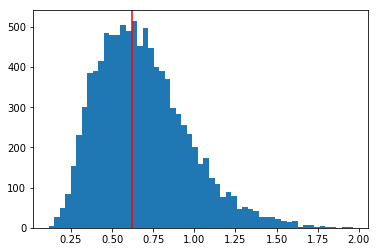

p-val: 0.5431


In [80]:
widgets.interact_manual(fun, mu_order = (-7, 0, 1), alpha = (0.0, 0.5, 0.01), b0=(1, 9), b1=(1, 9), b2=(1, 9), b3=(1, 9), b4=(1, 9), max_lag=(6, 18), norm=[1, 2, 4, np.inf])